In [251]:
!pip install lime


# Data Collection and Loading

In this phase, we imported the required libraries and mounted Google Drive to access the dataset. The dataset is loaded from a specified path, and we verified successful loading by displaying the first few rows.



In [252]:
# General libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
# Scikit-learn for preprocessing, model selection, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
# Import KNN imputer for numerical columns
from sklearn.impute import KNNImputer
# For LIME (Local Interpretable Model-agnostic Explanations)
import lime
import lime.lime_tabular

In [253]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
# Load the dataset from the given path
file_path = '/content/drive/MyDrive/Chronic kidney disease/chronic_kidney_disease (1).csv'
ckd_data = pd.read_csv(file_path)

# Display the first few rows to verify loading
ckd_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


#Checking for Missing Values of data set
####I use the dataset.isnull().sum() function to identify any missing values (NaN) in each column of my dataset.
####This function scans each column and counts how many entries are missing, providing a summary of all columns with their respective counts of missing values.
#####This step is crucial for understanding the completeness of my data and determining if I need to handle any missing information before proceeding with further analysis or modeling.

In [255]:
# Cheaking Missing
ckd_data.isnull().sum()

,0
age,9
bp,12
sg,47
al,46
su,49
rbc,152
pc,65
pcc,4
ba,4
bgr,44


##Viewing Column Names and Data Types
####I use dataset.columns to list all column names in my dataset, allowing me to see each feature available for analysis.
####Then, I use dataset.dtypes to display the data type of each column (e.g., float64, int64, object).
####This step helps me understand the structure of my dataset, including which columns are numerical and which are categorical, so I can plan appropriate preprocessing steps for each feature type.

In [256]:
# Display column names in DataFrame format
ckd_columns = pd.DataFrame(ckd_data.columns, columns=["Column Names"])
print("Column names in the dataset:")
print(ckd_columns)

# Display data types of each column in DataFrame format
ckd_dtypes = pd.DataFrame(ckd_data.dtypes, columns=["Data Types"])
print("\nData types of each column:")
print(ckd_dtypes)

Column names in the dataset:
   Column Names
0           age
1            bp
2            sg
3            al
4            su
5           rbc
6            pc
7           pcc
8            ba
9           bgr
10           bu
11           sc
12          sod
13          pot
14         hemo
15          pcv
16         wbcc
17         rbcc
18          htn
19           dm
20          cad
21        appet
22           pe
23          ane
24        class

Data types of each column:
      Data Types
age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object


In [257]:
# Function to detect inconsistencies in categorical data
def check_inconsistencies(df):
    # Dictionary to store results
    inconsistencies = {}

    # Loop through each column in the DataFrame
    for col in df.columns:
        # Only check object (categorical) columns
        if df[col].dtype == 'object':
            # Remove any leading/trailing whitespaces for comparison
            unique_values = df[col].dropna().unique()
            cleaned_values = [value.strip() for value in unique_values]

            # Identify values that differ before and after cleaning
            differences = set(unique_values) - set(cleaned_values)

            # Check for special characters or whitespace
            irregular_values = [val for val in unique_values if re.search(r'[\s\t]', val)]

            # If inconsistencies are found, add to the dictionary
            if differences or irregular_values:
                inconsistencies[col] = {
                    "Original Values": unique_values,
                    "Irregular Values": irregular_values,
                    "Differences After Cleaning": list(differences)
                }

    return inconsistencies

# Run the function on your dataset and print results
inconsistencies = check_inconsistencies(ckd_data)
for col, issue in inconsistencies.items():
    print(f"Inconsistencies in '{col}':")
    print("Original Values:", issue["Original Values"])
    print("Irregular Values:", issue["Irregular Values"])
    print("Differences After Cleaning:", issue["Differences After Cleaning"])
    print("\n" + "-"*50 + "\n")


Inconsistencies in 'dm':
Original Values: ['yes' 'no' '\tno']
Irregular Values: ['\tno']
Differences After Cleaning: ['\tno']

--------------------------------------------------

Inconsistencies in 'class':
Original Values: ['ckd' 'ckd\t' 'notckd']
Irregular Values: ['ckd\t']
Differences After Cleaning: ['ckd\t']

--------------------------------------------------



In [258]:
# Initialize dictionaries and counters to store results
categorical_like_yes_no = {}
columns_with_nan = []
categorical_count = 0
numerical_count = 0

# Loop through each column in the dataset, including 'class'
for col in ckd_data.columns:
    # Check data type to count categorical and numerical columns
    if ckd_data[col].dtype == 'object':
        categorical_count += 1  # Count as categorical
        unique_values = ckd_data[col].dropna().unique()  # Get unique values excluding NaN
        # Check for specified categorical values
        if any(val in ['yes', 'no', 'normal', 'abnormal', 'present', 'notpresent', 'good', 'poor', 'ckd', 'notckd'] for val in unique_values):
            categorical_like_yes_no[col] = unique_values
        # Check for NaN values in the column
        if ckd_data[col].isnull().sum() > 0:
            columns_with_nan.append(col)  # Add column to list if it contains NaN
    else:
        numerical_count += 1  # Count as numerical

# Display results
print("Columns with categorical values like 'yes', 'no', 'normal', etc.:")
for col, values in categorical_like_yes_no.items():
    print(f"Column '{col}' has categorical values:", values)

print("\nColumns with both categorical values and NaN values:")
for col in columns_with_nan:
    print(f"Column '{col}' has NaN values.")

print("\nTotal counts:")
print(f"Number of categorical columns: {categorical_count}")
print(f"Number of numerical columns: {numerical_count}")

# Additional check for the target 'class' column
if 'class' in categorical_like_yes_no:
    print("\nTarget column 'class' has the following values:", categorical_like_yes_no['class'])


Columns with categorical values like 'yes', 'no', 'normal', etc.:
Column 'rbc' has categorical values: ['normal' 'abnormal']
Column 'pc' has categorical values: ['normal' 'abnormal']
Column 'pcc' has categorical values: ['notpresent' 'present']
Column 'ba' has categorical values: ['notpresent' 'present']
Column 'htn' has categorical values: ['yes' 'no']
Column 'dm' has categorical values: ['yes' 'no' '\tno']
Column 'cad' has categorical values: ['no' 'yes']
Column 'appet' has categorical values: ['good' 'poor']
Column 'pe' has categorical values: ['no' 'yes']
Column 'ane' has categorical values: ['no' 'yes']
Column 'class' has categorical values: ['ckd' 'ckd\t' 'notckd']

Columns with both categorical values and NaN values:
Column 'rbc' has NaN values.
Column 'pc' has NaN values.
Column 'pcc' has NaN values.
Column 'ba' has NaN values.
Column 'htn' has NaN values.
Column 'dm' has NaN values.
Column 'cad' has NaN values.
Column 'appet' has NaN values.
Column 'pe' has NaN values.
Column 

In [259]:
# Fix inconsistencies in 'dm' and 'class' columns
ckd_data['dm'] = ckd_data['dm'].replace(to_replace={'\tyes': 'yes', ' yes': 'yes', '\tno': 'no'})
ckd_data['class'] = ckd_data['class'].replace(to_replace={'ckd\t': 'ckd'})

# Encode good signs as 1, bad signs as 0

# Red Blood Cells (rbc) - 'normal' -> 1 (good), 'abnormal' -> 0 (bad)
ckd_data['rbc'] = ckd_data['rbc'].replace({'normal': 1, 'abnormal': 0})
print("Value counts for 'rbc':")
print(ckd_data['rbc'].value_counts(), "\n")

# Pus Cells (pc) - 'normal' -> 1 (good), 'abnormal' -> 0 (bad)
ckd_data['pc'] = ckd_data['pc'].replace({'normal': 1, 'abnormal': 0})
print("Value counts for 'pc':")
print(ckd_data['pc'].value_counts(), "\n")

# Pus Cell Clumps (pcc) - 'notpresent' -> 1 (good), 'present' -> 0 (bad)
ckd_data['pcc'] = ckd_data['pcc'].replace({'notpresent': 1, 'present': 0})
print("Value counts for 'pcc':")
print(ckd_data['pcc'].value_counts(), "\n")

# Bacteria (ba) - 'notpresent' -> 1 (good), 'present' -> 0 (bad)
ckd_data['ba'] = ckd_data['ba'].replace({'notpresent': 1, 'present': 0})
print("Value counts for 'ba':")
print(ckd_data['ba'].value_counts(), "\n")

# Hypertension (htn) - 'no' -> 1 (good), 'yes' -> 0 (bad)
ckd_data['htn'] = ckd_data['htn'].replace({'no': 1, 'yes': 0})
print("Value counts for 'htn':")
print(ckd_data['htn'].value_counts(), "\n")

# Diabetes Mellitus (dm) - 'no' -> 1 (good), 'yes' -> 0 (bad)
ckd_data['dm'] = ckd_data['dm'].replace({'no': 1, 'yes': 0})
print("Value counts for 'dm':")
print(ckd_data['dm'].value_counts(), "\n")

# Coronary Artery Disease (cad) - 'no' -> 1 (good), 'yes' -> 0 (bad)
ckd_data['cad'] = ckd_data['cad'].replace({'no': 1, 'yes': 0})
print("Value counts for 'cad':")
print(ckd_data['cad'].value_counts(), "\n")

# Appetite (appet) - 'good' -> 1 (good), 'poor' -> 0 (bad)
ckd_data['appet'] = ckd_data['appet'].replace({'good': 1, 'poor': 0})
print("Value counts for 'appet':")
print(ckd_data['appet'].value_counts(), "\n")

# Pedal Edema (pe) - 'no' -> 1 (good), 'yes' -> 0 (bad)
ckd_data['pe'] = ckd_data['pe'].replace({'no': 1, 'yes': 0})
print("Value counts for 'pe':")
print(ckd_data['pe'].value_counts(), "\n")

# Anemia (ane) - 'no' -> 1 (good), 'yes' -> 0 (bad)
ckd_data['ane'] = ckd_data['ane'].replace({'no': 1, 'yes': 0})
print("Value counts for 'ane':")
print(ckd_data['ane'].value_counts(), "\n")

# Target Column - 'notckd' -> 1 (good), 'ckd' -> 0 (bad)
ckd_data['class'] = ckd_data['class'].replace({'notckd': 1, 'ckd': 0})
print("Value counts for 'class':")
print(ckd_data['class'].value_counts(), "\n")

# Display the first few rows to verify the transformation
ckd_data.head()


Value counts for 'rbc':
rbc
1    201
0     47
Name: count, dtype: int64 

Value counts for 'pc':
pc
1    259
0     76
Name: count, dtype: int64 

Value counts for 'pcc':
pcc
1    354
0     42
Name: count, dtype: int64 

Value counts for 'ba':
ba
1    374
0     22
Name: count, dtype: int64 

Value counts for 'htn':
htn
1    251
0    147
Name: count, dtype: int64 

Value counts for 'dm':
dm
1    261
0    137
Name: count, dtype: int64 

Value counts for 'cad':
cad
1    364
0     34
Name: count, dtype: int64 

Value counts for 'appet':
appet
1    317
0     82
Name: count, dtype: int64 

Value counts for 'pe':
pe
1    323
0     76
Name: count, dtype: int64 

Value counts for 'ane':
ane
1    339
0     60
Name: count, dtype: int64 

Value counts for 'class':
class
0    250
1    150
Name: count, dtype: int64 



,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,1,1,1,121.0,...,44.0,7800.0,5.2,0,0,1,1,1,1,0
1,7.0,50.0,1.020,4.0,0.0,NaN,1,1,1,NaN,...,38.0,6000.0,NaN,1,1,1,1,1,1,0
2,62.0,80.0,1.010,2.0,3.0,1,1,1,1,423.0,...,31.0,7500.0,NaN,1,0,1,0,1,0,0
3,48.0,70.0,1.005,4.0,0.0,1,0,0,1,117.0,...,32.0,6700.0,3.9,0,1,1,0,0,0,0
4,51.0,80.0,1.010,2.0,0.0,1,1,1,1,106.0,...,35.0,7300.0,4.6,1,1,1,1,1,1,0


In [260]:
# Save the cleaned and encoded dataset to a new CSV file
ckd_data.to_csv("encoded_ckd_data.csv", index=False)

print("\nDataset has been saved as 'encoded_ckd_data.csv'")



Dataset has been saved as 'encoded_ckd_data.csv'


# Data Preprocessing

## Checking for Null Values in the Encoded Dataset

######Now that I have saved the cleaned and encoded dataset, I'll reload it to verify that all preprocessing steps have been applied correctly.
######I’ll check the data types of each column to ensure that categorical values have been properly converted, and then I’ll identify any remaining null values in the dataset.



In [261]:
# Load the saved dataset
saved_ckd_data = pd.read_csv("encoded_ckd_data.csv")

# Display the data types of each column in the saved dataset
print("Data types of each column in the saved dataset:")
print(saved_ckd_data.dtypes)


Data types of each column in the saved dataset:
age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc      float64
pc       float64
pcc      float64
ba       float64
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn      float64
dm       float64
cad      float64
appet    float64
pe       float64
ane      float64
class      int64
dtype: object


In [262]:
# Check for any remaining null values
print("\nChecking for remaining null values in each column:")
print(saved_ckd_data.isnull().sum())



Checking for remaining null values in each column:
age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64


## Handling Missing Values in the Encoded Dataset

######Upon reloading and inspecting the encoded dataset, I observed that several columns still contain missing values.
######In this next step, I’ll apply imputation techniques to fill in these missing values to ensure the data is complete and ready for analysis.
######I’ll use **K-Nearest Neighbors (KNN) imputation** for numerical columns and **mode imputation** for any remaining categorical columns, as these methods preserve the dataset's integrity without introducing bias.


In [263]:
# Create a KNN imputer instance (choosing k=5 as a reasonable default)
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation on the dataset
# Here, KNN will impute only the numerical columns as they are in float or int format.
imputed_data = knn_imputer.fit_transform(saved_ckd_data)

# Convert the imputed data back to a DataFrame with the original column names
saved_ckd_data_imputed = pd.DataFrame(imputed_data, columns=saved_ckd_data.columns)

# Display the data types again to verify changes
print("Data types of each column after imputation:")
print(saved_ckd_data_imputed.dtypes)

# Check for any remaining null values after imputation
print("\nChecking for remaining null values in each column after imputation:")
print(saved_ckd_data_imputed.isnull().sum())

Data types of each column after imputation:
age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc      float64
pc       float64
pcc      float64
ba       float64
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn      float64
dm       float64
cad      float64
appet    float64
pe       float64
ane      float64
class    float64
dtype: object

Checking for remaining null values in each column after imputation:
age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64


# Exploratory Data Analysis (EDA)


In this part of the analysis, I'll examine the distribution of the target variable, `class`, to understand the balance between CKD and non-CKD cases. This will give me insights into whether the dataset is imbalanced, which can affect model performance. If there is a significant imbalance, it may be necessary to apply resampling techniques to ensure fair model training.


In [264]:
# Display the class distribution in the target variable
print("Class distribution in the dataset:")
print(saved_ckd_data_imputed['class'].value_counts())

# Calculate the percentage distribution of each class
print("\nPercentage distribution of each class:")
print(saved_ckd_data_imputed['class'].value_counts(normalize=True) * 100)


Class distribution in the dataset:
class
0.0    250
1.0    150
Name: count, dtype: int64

Percentage distribution of each class:
class
0.0    62.5
1.0    37.5
Name: proportion, dtype: float64


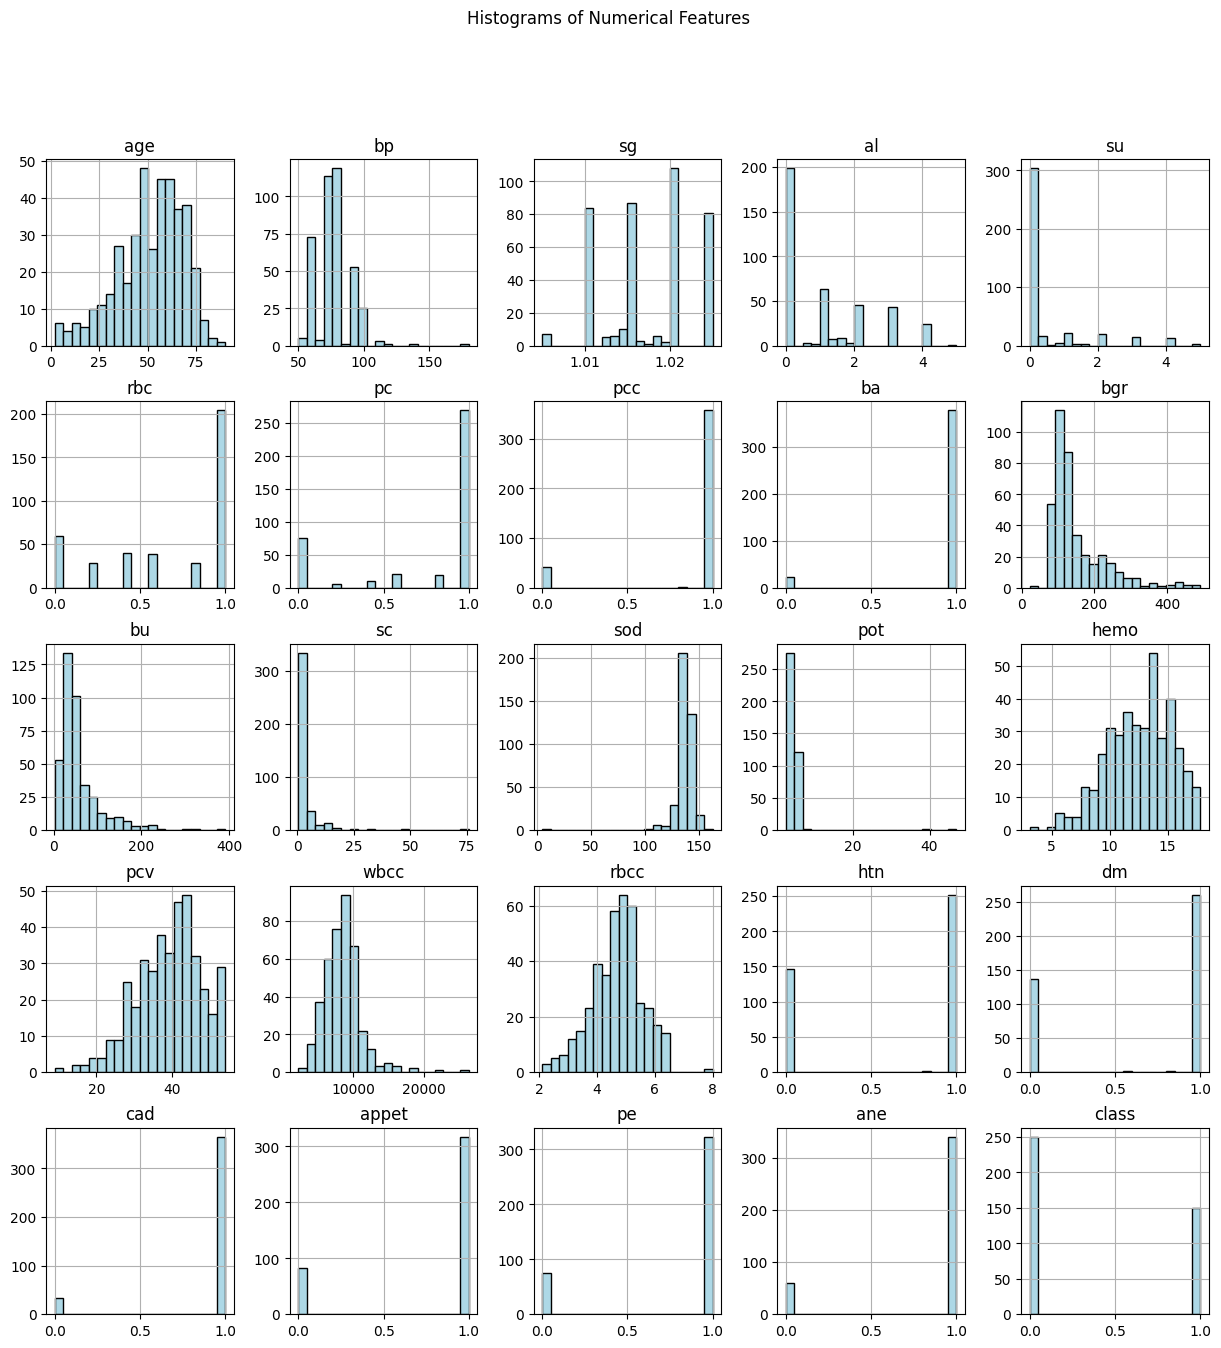

In [265]:
# Plot histograms for numerical features to observe their distributions
saved_ckd_data_imputed.hist(figsize=(15, 15), bins=20, color='lightblue', edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()


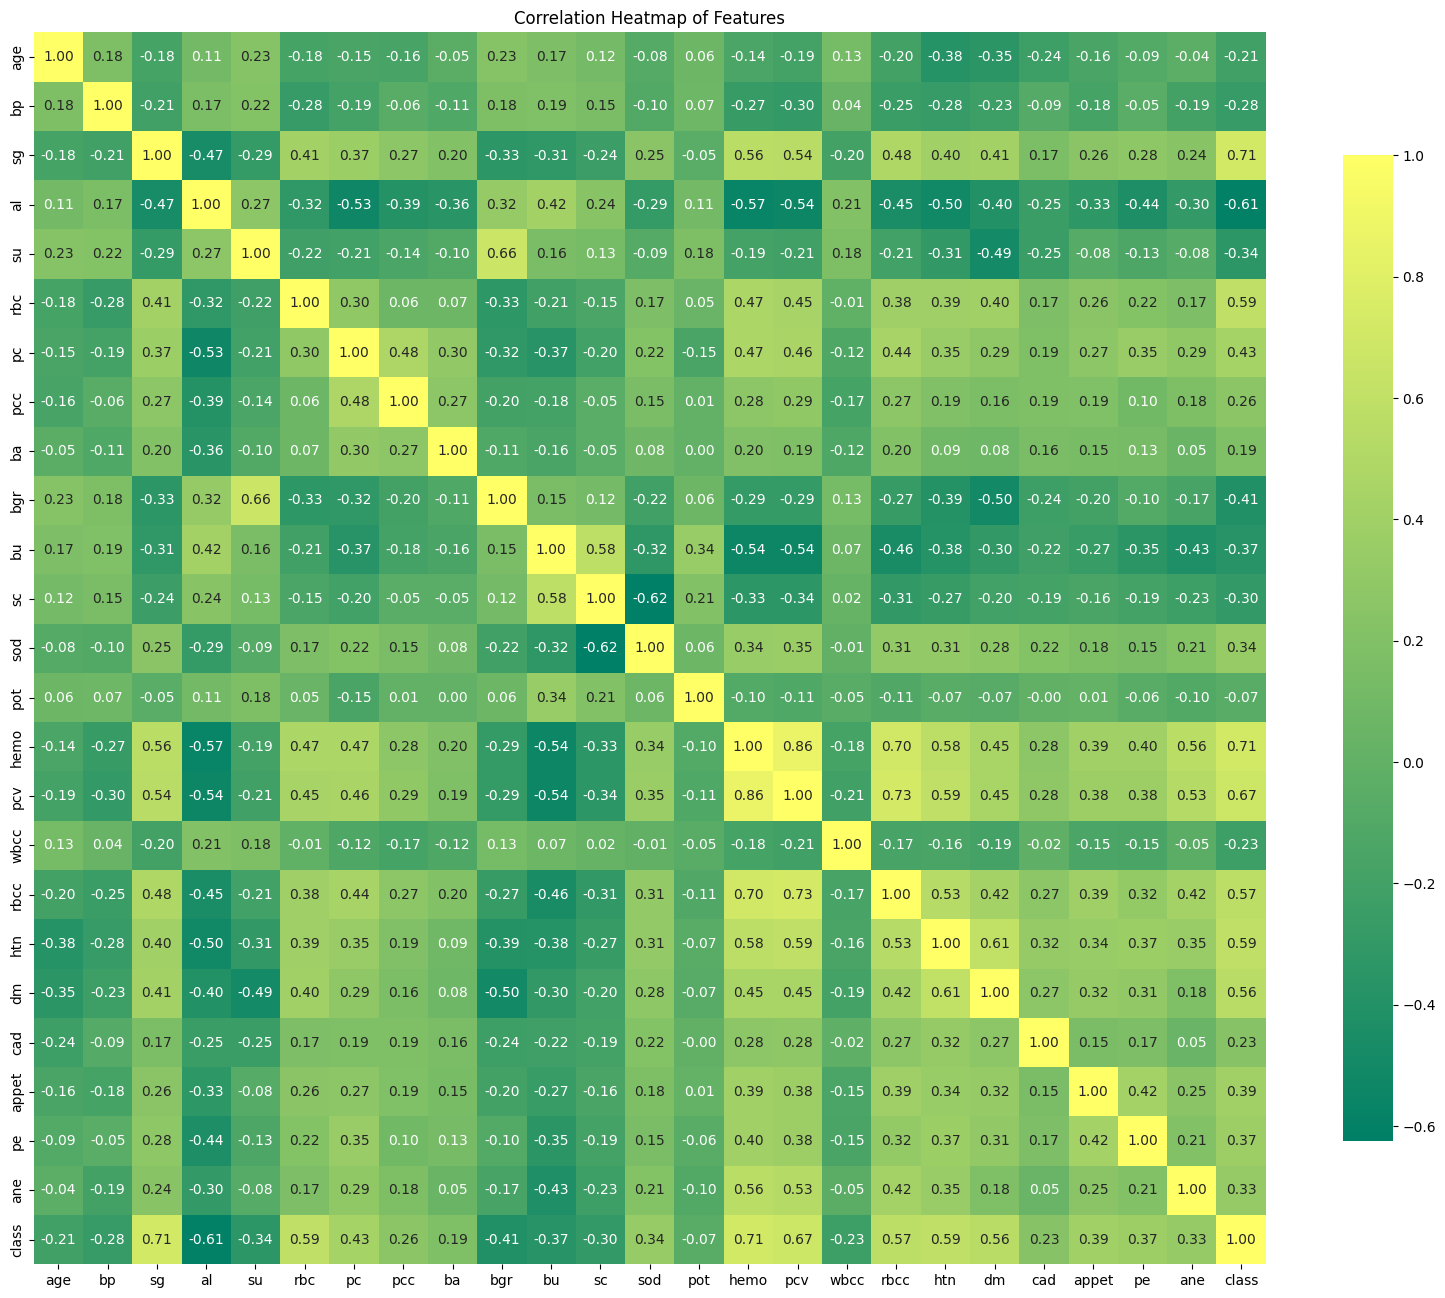

In [266]:
# Calculate correlation matrix for numerical features
corr_matrix = saved_ckd_data_imputed.corr()

# Plot correlation heatmap with more space
plt.figure(figsize=(20, 16))  # Increased the figure size for more space
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="summer", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Features")
plt.show()


### Observation: Correlation Between `pcv` and `hemo`

In the correlation heatmap, I observed a strong positive correlation between the features `pcv` (packed cell volume) and `hemo` (hemoglobin level), with a correlation value of approximately **0.86**. This high correlation indicates that `pcv` and `hemo` are closely related, likely capturing similar physiological information.

#### Implications of High Multicollinearity
This strong relationship suggests potential multicollinearity, where both features may provide redundant information to the model. High multicollinearity between features can lead to inflated variance in model coefficients, making it harder to interpret the influence of each feature accurately.

#### Feature Selection Consideration
Given this high correlation, I may consider retaining only one of these features (either `pcv` or `hemo`) for the final model to reduce redundancy. By selecting one representative feature, I can simplify the model without sacrificing much predictive power, leading to better interpretability and efficiency.



### Removing Highly Correlated Feature: `pcv`

Based on the correlation analysis, I observed that `pcv` (packed cell volume) and `hemo` (hemoglobin level) have a high correlation (approximately 0.86), indicating potential multicollinearity. To simplify the dataset and avoid redundancy, I’ll remove the `pcv` column, retaining `hemo` as the representative feature. This step helps improve model interpretability by reducing the influence of redundant features.

After removing `pcv`, I’ll display the first few rows of the dataset to confirm the change.


In [267]:
# Remove the 'pcv' column to reduce multicollinearity
saved_ckd_data_imputed.drop('pcv', axis=1, inplace=True)

# Display the first few rows to confirm the removal of 'pcv'
saved_ckd_data_imputed.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.8,1.0,1.0,1.0,121.0,...,15.4,7800.0,5.20,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1,7.0,50.0,1.020,4.0,0.0,0.6,1.0,1.0,1.0,113.0,...,11.3,6000.0,4.96,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,1.0,1.0,423.0,...,9.6,7500.0,3.80,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,0.0,1.0,117.0,...,11.2,6700.0,3.90,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,1.0,1.0,106.0,...,11.6,7300.0,4.60,1.0,1.0,1.0,1.0,1.0,1.0,0.0


### Visualizing the Distribution of the Target Feature: `class`

To understand the balance between classes in the target feature (`classification`), I’ll use a count plot to visualize the distribution. This visualization helps me identify if there’s any class imbalance, which can impact model performance. If one class significantly outnumbers the other, I may need to apply resampling techniques to ensure balanced training data.


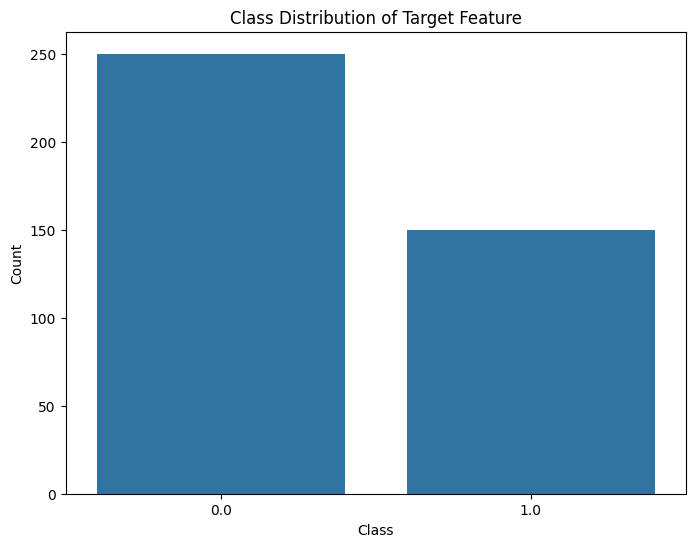

In [268]:
# Set a larger figure size for readability
plt.figure(figsize=(8, 6))

# Plot the distribution of the target feature with adjusted parameters
sns.countplot(x='class', data=saved_ckd_data_imputed)
plt.title("Class Distribution of Target Feature")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


### Separating Independent and Dependent Features

In this step, I’ll separate the dataset into **independent features (X)** and the **dependent feature (y)**. The independent features (`X`) include all columns except the target variable, while the dependent feature (`y`) contains only the target column, which the model will learn to predict. This separation is essential for supervised machine learning, as it defines what the model will use as input (`X`) and what it will predict (`y`).


In [269]:
# Independent and Dependent Feature separation
X = saved_ckd_data_imputed.iloc[:, :-1]  # All columns except the last one
y = saved_ckd_data_imputed.iloc[:, -1]   # Only the last column (target)

# Display the first few rows of X to confirm the separation
X.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pot,hemo,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,0.8,1.0,1.0,1.0,121.0,...,4.20,15.4,7800.0,5.20,0.0,0.0,1.0,1.0,1.0,1.0
1,7.0,50.0,1.020,4.0,0.0,0.6,1.0,1.0,1.0,113.0,...,3.92,11.3,6000.0,4.96,1.0,1.0,1.0,1.0,1.0,1.0
2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,1.0,1.0,423.0,...,4.20,9.6,7500.0,3.80,1.0,0.0,1.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,0.0,1.0,117.0,...,2.50,11.2,6700.0,3.90,0.0,1.0,1.0,0.0,0.0,0.0
4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,1.0,1.0,106.0,...,3.98,11.6,7300.0,4.60,1.0,1.0,1.0,1.0,1.0,1.0


### Feature Importance Analysis Using ExtraTreesClassifier

In this step, I'll use the `ExtraTreesClassifier` to analyze the importance of each feature in predicting the target variable. Feature importance helps identify which features have the most influence on the model's predictions. Focusing on the most important features can improve model performance and interpretability by reducing complexity.

I will plot the top 24 most important features to visualize which ones contribute the most to the model’s accuracy.


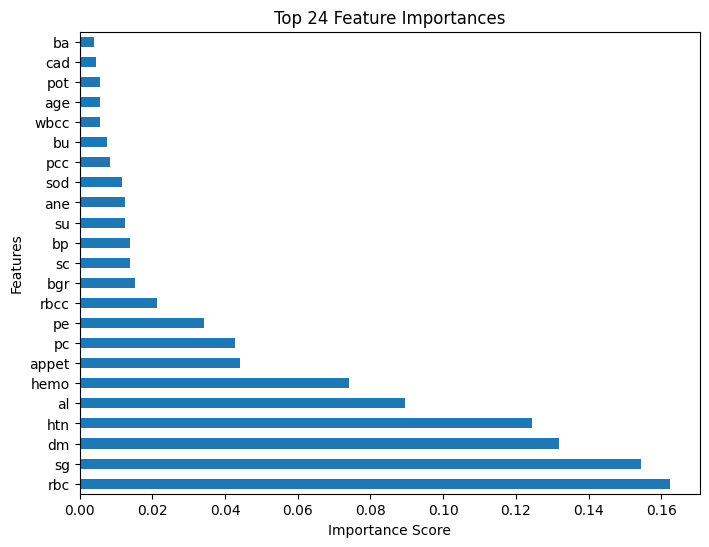

In [270]:
# Import the necessary libraries
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the model
model = ExtraTreesClassifier()

# Fit the model to the dataset
model.fit(X, y)

# Set the figure size for better readability
plt.figure(figsize=(8, 6))

# Create a Series with feature importance scores, indexed by feature names
ranked_features = pd.Series(model.feature_importances_, index=X.columns)

# Plot the top 24 most important features as a horizontal bar chart
ranked_features.nlargest(24).plot(kind='barh')
plt.title("Top 24 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


### Analysis of Top Features Based on Feature Importance

From the feature importance plot, I observed that certain features stand out as the most influential in predicting Chronic Kidney Disease (CKD). Here are the top features I identified:

1. **rbc (Red Blood Cells)**: This feature has the highest importance score, suggesting that red blood cell count is a crucial predictor for CKD in my dataset.

2. **sg (Specific Gravity)**: With a high importance score, specific gravity is closely related to kidney function, making it a key factor for CKD prediction.

3. **htn (Hypertension)**: The presence of hypertension is another significant feature, as high blood pressure is a major factor affecting kidney health.

4. **hemo (Hemoglobin)**: Hemoglobin levels are highly relevant since anemia is often associated with kidney disease, indicating that this feature is valuable for the model.

5. **al (Albumin)**: Albumin levels in urine can signal protein leakage, which is an important indicator of kidney damage.

6. **dm (Diabetes Mellitus)**: Diabetes is a leading cause of CKD, and the model recognizes its importance in predicting kidney disease.

7. **appet (Appetite)**: Loss of appetite is a common symptom in advanced kidney disease, so it’s noteworthy that this feature has high importance.

8. **pc (Pus Cells)**: The presence of pus cells in urine may indicate infection, which can be linked to kidney health issues.

These top features align well with known medical indicators of kidney health.
next steps, I could focus on these key features to potentially improve the model’s efficiency and interpretability.


### Identifying the Top 8 Most Important Features

To make my model more efficient, I want to focus on the features that have the greatest impact on predicting CKD. By identifying the top 8 most important features based on their importance scores, I can create a simplified version of the dataset that still retains the key predictive information. This approach allows me to reduce complexity while keeping the model effective.


In [271]:
# Get the names of the top 8 most important features
top_8_features = ranked_features.nlargest(8).index

# Display the top 8 feature names
print("Top 8 most important features:", top_8_features.tolist())


Top 8 most important features: ['rbc', 'sg', 'dm', 'htn', 'al', 'hemo', 'appet', 'pc']


### Creating a Subset with the Top 8 Features

Based on the feature importance analysis, I identified the top 8 most important features: `rbc`, `sg`, `htn`, `hemo`, `al`, `dm`, `appet`, and `pc`. To simplify the model and focus on the most impactful predictors, I'll create a subset of the dataset that includes only these top features along with the target variable. Using this reduced dataset may improve the model’s efficiency and interpretability by eliminating less relevant features.


In [272]:
# Create a subset of the dataset with only the top 8 most important features
X_top_features = saved_ckd_data_imputed[top_8_features]

# Display the first few rows of the subset to confirm
X_top_features.head()


,rbc,sg,dm,htn,al,hemo,appet,pc
0,0.8,1.020,0.0,0.0,1.0,15.4,1.0,1.0
1,0.6,1.020,1.0,1.0,4.0,11.3,1.0,1.0
2,1.0,1.010,0.0,1.0,2.0,9.6,0.0,1.0
3,1.0,1.005,1.0,0.0,4.0,11.2,0.0,0.0
4,1.0,1.010,1.0,1.0,2.0,11.6,1.0,1.0


### Verifying the Structure of Feature Matrix (X) and Target Variable (y)

To ensure that my dataset is correctly set up for modeling, I’ll take a quick look at the last few rows of my feature matrix (`X`) and the first few rows of my target variable (`y`). This check helps confirm that `X` contains only the selected top 8 features, and `y` contains the target labels (CKD classification) that I want to predict.


In [273]:
# Display the last few rows of X_top_features to verify structure
print("\nLast few rows of X_top_features:")
print(X_top_features.tail())

# Display the first few rows of the target variable y
print("\nFirst few rows of the target variable y:")
print(y.head())


Last few rows of X_top_features:
     rbc     sg   dm  htn   al  hemo  appet   pc
395  1.0  1.020  1.0  1.0  0.0  15.7    1.0  1.0
396  1.0  1.025  1.0  1.0  0.0  16.5    1.0  1.0
397  1.0  1.020  1.0  1.0  0.0  15.8    1.0  1.0
398  1.0  1.025  1.0  1.0  0.0  14.2    1.0  1.0
399  1.0  1.025  1.0  1.0  0.0  15.8    1.0  1.0

First few rows of the target variable y:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float64


In [274]:
# Display the first few rows of the target variable y to verify its contents
y.head()


,class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


### Data Scaling with Min-Max Scaling

Since I’ve already selected the top 8 most important features, I’ll now apply **Min-Max Scaling** to ensure all features are on a similar scale between 0 and 1. This step is essential for many machine learning models, as it helps standardize the input range and improves model performance and training stability.


In [275]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the top features
X_scaled = scaler.fit_transform(X_top_features)

# Convert the scaled array back to a DataFrame with the original column names
X_scaled = pd.DataFrame(X_scaled, columns=X_top_features.columns)

# Display the first few rows of the scaled features to confirm
X_scaled.head()


,rbc,sg,dm,htn,al,hemo,appet,pc
0,0.8,0.75,0.0,0.0,0.2,0.836735,1.0,1.0
1,0.6,0.75,1.0,1.0,0.8,0.557823,1.0,1.0
2,1.0,0.25,0.0,1.0,0.4,0.442177,0.0,1.0
3,1.0,0.00,1.0,0.0,0.8,0.551020,0.0,0.0
4,1.0,0.25,1.0,1.0,0.4,0.578231,1.0,1.0


### Data Splitting for Training and Testing

Now that the data is scaled, I’ll split it into training and testing sets. I’ll use 80% of the data for training and 20% for testing, which allows the model to learn from most of the data while keeping a portion aside for evaluation. This step is critical to ensure that the model’s performance is assessed on unseen data, providing a more reliable measure of its effectiveness.


In [276]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=33)

# Display the shapes of the resulting datasets to confirm
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training target set shape:", y_train.shape)
print("Testing target set shape:", y_test.shape)


Training feature set shape: (280, 23)
Testing feature set shape: (120, 23)
Training target set shape: (280,)
Testing target set shape: (120,)


### Model Development: Initial Model with Decision Tree Classifier

To begin model development, I’ll train an initial **Decision Tree Classifier** on the data. This model is a good starting point due to its simplicity and interpretability, allowing us to see how well the selected features perform in predicting CKD. After training the model, I’ll evaluate its performance on the test set using accuracy, precision, recall, and F1-score.


In [277]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the evaluation metrics
print("Decision Tree Model Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Decision Tree Model Performance:
Accuracy: 0.96
Precision: 0.95
Recall: 0.97
F1-Score: 0.96


### Hyperparameter Tuning for Decision Tree Model

To improve the Decision Tree model, I’ll use **GridSearchCV** to perform hyperparameter tuning. This process tests different combinations of parameters, allowing me to find the settings that yield the best performance. The primary parameters I’ll tune include `max_depth` and `min_samples_split`, which help control the tree’s complexity and generalizability.


In [278]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20]
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Extract the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Display the best parameters and score
print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)


Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.9428571428571428


### Final Model Evaluation with Tuned Decision Tree

Using the best parameters identified from GridSearchCV (`max_depth=3` and `min_samples_split=2`), I’ll now train the final Decision Tree model and evaluate its performance on the test set. This final evaluation will confirm the model's accuracy and reliability on unseen data.


In [279]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train the final model with the best parameters on the training data
final_model = DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=42)
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred_final = final_model.predict(X_test)

# Calculate evaluation metrics
accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

# Display the evaluation metrics for the tuned model
print("Tuned Decision Tree Model Performance on Test Set:")
print(f"Accuracy: {accuracy_final:.2f}")
print(f"Precision: {precision_final:.2f}")
print(f"Recall: {recall_final:.2f}")
print(f"F1-Score: {f1_final:.2f}")


Tuned Decision Tree Model Performance on Test Set:
Accuracy: 0.94
Precision: 0.95
Recall: 0.93
F1-Score: 0.94


### Explainable AI with LIME: Interpreting Individual Predictions

To make the model’s predictions interpretable, I’ll use **LIME (Local Interpretable Model-agnostic Explanations)**. LIME helps to explain why the model made a certain prediction for specific instances. This technique is valuable for understanding individual predictions, especially in a healthcare setting where interpretability is critical. I’ll demonstrate LIME on a few instances from the test set.


In [280]:
import lime
import lime.lime_tabular
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Initialize LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,  # Use the training data to create the explainer
    feature_names=X_train.columns,
    class_names=['non-CKD', 'CKD'],  # Assuming 1 is CKD and 0 is non-CKD
    mode='classification'
)

# Select an instance from the test set to explain, keeping it as a DataFrame to retain feature names
instance_idx = 5  # You can change this index to explain different instances
instance = X_test.iloc[[instance_idx]]  # Using double brackets to keep it as a DataFrame

# Generate explanation for the selected instance
explanation = explainer.explain_instance(
    instance.values[0],  # LIME expects a single row without DataFrame structure here
    final_model.predict_proba  # Use the probability predictions from the model
)

# Display the explanation in a plot
explanation.show_in_notebook(show_all=False)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### LIME Explanation of the Model's Prediction

After applying LIME, I observed that the model provided a detailed explanation of its prediction for the selected test instance, which was classified as **non-CKD**. Here’s a breakdown of the results:

1. **Prediction Probabilities**:
   - The model predicted a **92% probability for non-CKD** and only an **8% probability for CKD** for this instance. With such a high probability, the model confidently classified this instance as non-CKD.

2. **Key Feature Contributions**:
   - LIME highlighted the features that most influenced this non-CKD prediction, along with how each feature contributed:
     - **`rbcc > 5.20` (Red Blood Cell Count)**: This feature had the largest influence, with a contribution of **0.49** towards predicting non-CKD. A higher red blood cell count is often a good indicator of normal function.
     - **`12.53 < hemo <= 14.37` (Hemoglobin)**: The hemoglobin level contributed **0.12** toward non-CKD, suggesting that values in this range support the model’s non-CKD prediction.
     - **`bgr > 193.85` (Blood Glucose Random)**: Although elevated blood glucose can be a CKD risk factor, here, it contributed **0.09** toward non-CKD.
     - **`sg <= 1.01` (Specific Gravity)**: Specific gravity at this level added **0.08** to the non-CKD prediction.
     - **`al <= 0.00` (Albumin)**: The absence of albumin (protein in urine) contributed **0.07** towards non-CKD, supporting the prediction that the patient doesn’t have CKD.

3. **Feature Values for the Instance**:
   - For this specific test instance, I noted the actual values of the important features:
     - **`rbcc`**: 5.26
     - **`hemo`**: 13.74
     - **`bgr`**: 256.00
     - **`sg`**: 1.01
     - **`age`**: 69.00, among others.
   - These values align well with the ranges shown above, which explains why the model leaned towards a non-CKD prediction.

### Summary of My Observations

Based on these results, I can see that the model’s decision to classify this instance as non-CKD was influenced most by the red blood cell count, hemoglobin level, and absence of albumin. This explanation from LIME offers a transparent view into how specific feature values led to the prediction, making the model's decision-making process clearer and more interpretable. This interpretability is essential for ensuring trust in the model's predictions, especially in healthcare-related applications.
